## **引入套件**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from libarary import arima_tools
from pmdarima.utils import diff_inv

import argparse
import os
import warnings
warnings.filterwarnings("ignore")

# parser = argparse.ArgumentParser()
# parser.add_argument('--filename', required=True, help='Enter filename')
# parser.add_argument('--test-ratio', defualt=0.2, help='test ratio')
# args = parser.parse_args()

## **讀取檔案**

In [2]:
preprocessed_path = './data/preprocessed_data'
corr_matrix = pd.read_csv(os.path.join(preprocessed_path, '1101_2330.csv'), index_col='date', parse_dates=True)
corr_matrix = corr_matrix.dropna()

## **平穩化**

In [3]:
diff_dict = {}
for col in corr_matrix.columns:
    if col == 'date':
        continue
    differenced_series = corr_matrix[col].copy()
    diff = 0
    isStationary = arima_tools.adf_test(corr_matrix[col])
    while not isStationary:
        diff += 1
        differenced_series = differenced_series.diff().dropna()
        isStationary = arima_tools.adf_test(differenced_series)
    diff_dict[col] = diff
max_diff = max(diff_dict.values())
print(max_diff)

1


In [4]:
transformed_matrix = corr_matrix.copy()
for i in range(max_diff):
    transformed_matrix = transformed_matrix.diff().dropna()

## **資料分割**

In [5]:
nobs = int(len(transformed_matrix) * 0.2)
train, test = transformed_matrix[0:-nobs], transformed_matrix[-nobs:]

## **auto_arima**

In [6]:
order_dict = {}
for col in transformed_matrix.columns:
    auto_model = auto_arima(transformed_matrix[col], start_p=0, start_q=0, max_p=6, 
            max_q=6, error_action='ignore', suppress_warnings=True, seasonal=False)
    info =[auto_model.order, auto_model.aic(), auto_model.bic()]
    order_dict[col] = info

In [7]:
order_dict

{'Dealer_buy': [(0, 0, 2), 123.47145109393338, 132.93132587742673],
 'Foreign_Investor_buy': [(0, 0, 1), 96.8437351608511, 103.15031834984666],
 'Investment_Trust_buy': [(0, 0, 1), 88.5813010887592, 94.88788427775476],
 'Dealer_sell': [(0, 0, 1), 112.04523841693609, 118.35182160593165],
 'Foreign_Investor_sell': [(0, 0, 1), 109.28512084085618, 115.59170402985174],
 'Investment_Trust_sell': [(1, 0, 2), 96.19175850496646, 108.80492488295758],
 'MarginPurchaseBuy': [(0, 0, 1), 73.16957427835217, 79.47615746734773],
 'MarginPurchaseSell': [(0, 0, 1), 92.43534720023172, 98.74193038922728],
 'ShortSaleBuy': [(0, 0, 1), 104.56355377287187, 110.87013696186743],
 'ShortSaleSell': [(6, 0, 0), 82.83433153242962, 104.90737269391407],
 'Trading_Volume': [(5, 0, 0), 123.0118248096636, 141.93157437665027],
 'Trading_money': [(5, 0, 0), 119.89186099273063, 138.8116105597173],
 'open': [(0, 0, 1), 241.01760298957916, 247.3241861785747],
 'max': [(0, 0, 1), 254.71802673931896, 261.02460992831453],
 'min

In [8]:
order = arima_tools.getOrder(order_dict)
preferred_order = (order[0], order[2])
preferred_order

(0, 1)

## **VARMA**

In [9]:
train_model = VARMAX(train, order=preferred_order, trend='c')
varma_train_result = train_model.fit(maxister=1000, disp=False)

## **VARMA 預測**

In [10]:
varma_test_forecast = arima_tools.test_set_forecast(varma_train_result, test) # 測試資料集
varma_train_predict = arima_tools.train_set_predict(varma_train_result, train) #訓練資料集

In [11]:
if max_diff > 0 :
    varma_test_forecast = arima_tools.indiff(varma_test_forecast, corr_matrix, max_diff, 1, nobs)
    varma_train_predict = arima_tools.indiff(varma_train_predict, corr_matrix, max_diff, 0, nobs)

## **Evaluation**

In [12]:
df_error = pd.DataFrame(columns=['mean', 'VARMA RMSE (test)', 'VARMA RMSE (train)', 'VARMA RMSE', 'ARIMA RMSE (test)', 'ARIMA RMSE (train)', 'ARIMA RMSE'])
for col in varma_test_forecast.columns:
    varma_testRMSE = rmse(corr_matrix[col].iloc[-nobs:], varma_test_forecast[col])
    vrama_trainRMSE = rmse(corr_matrix[col].iloc[max_diff:len(corr_matrix)-nobs], varma_train_predict[col])
    df_error.loc[col, 'VARMA RMSE (test)'] = varma_testRMSE
    df_error.loc[col, 'VARMA RMSE (train)'] = vrama_trainRMSE
    df_error.loc[col, 'mean'] = corr_matrix[col].mean()

## **VARMA re-fit**

In [27]:
varma_model = VARMAX(transformed_matrix, order=preferred_order, trend='c')
varma_result = varma_model.fit(maxister=1000, disp=False)
varma_prediction = arima_tools.train_set_predict(varma_result, transformed_matrix) # 整段序列資料
if max_diff > 0 :
    varma_prediction = arima_tools.indiff(varma_prediction, corr_matrix, max_diff, 0, nobs)

In [28]:
for col in varma_prediction.columns:
    varma_wholeRMSE = rmse(corr_matrix[col].iloc[max_diff:], varma_prediction[col])
    df_error.loc[col, 'VARMA RMSE'] = varma_wholeRMSE

In [29]:
df_error

mean VARMA RMSE (test) VARMA RMSE (train)  \
Dealer_buy              0.13867          0.437191           0.497521   
Foreign_Investor_buy   0.373115          0.335248           0.514881   
Investment_Trust_buy   0.103474          0.425755           0.509903   
Dealer_sell             0.20077          0.475667           0.394915   
Foreign_Investor_sell  0.390889          0.360318           0.363261   
Investment_Trust_sell  0.059727          0.435394           0.376908   
MarginPurchaseBuy      0.053391          0.312142           0.536695   
MarginPurchaseSell     0.172912          0.498095           0.313567   
ShortSaleBuy           0.130155          0.258874           0.418245   
ShortSaleSell          0.085776          0.333567           0.329264   
Trading_Volume         0.330599          0.429647           0.334188   
Trading_money          0.326057           0.42585           0.340888   
open                    0.32643          0.822543           0.495125   
max                    0.321153          0.777033            0.50051   
min                    0.357952          0.741736           0.493095   
close                  0.349972           0.67858           0.477251   
spread                  0.33992          0.307124           0.289563   
Trading_turnover       0.273373          0.351031           0.328019   

                      VARMA RMSE ARIMA RMSE (test) ARIMA RMSE (train)  \
Dealer_buy              0.482837           0.43506           0.321552   
Foreign_Investor_buy    0.354845          0.319696           0.304813   
Investment_Trust_buy    0.445913          0.287185           0.308466   
Dealer_sell             0.430713          0.382612            0.32916   
Foreign_Investor_sell   0.512066          0.351377           0.312142   
Investment_Trust_sell   0.614632          0.385105           0.283681   
MarginPurchaseBuy       0.426849          0.267333           0.299527   
MarginPurchaseSell      0.431049          0.314307           0.301136   
ShortSaleBuy            0.416477          0.264232           0.332748   
ShortSaleSell           0.336077          0.271639            0.27862   
Trading_Volume          0.346151          0.383153           0.299776   
Trading_money           0.351725          0.382077           0.297336   
open                    0.774375           0.49293            0.46862   
max                     0.802244          0.526012           0.480629   
min                     0.745354          0.513453           0.483664   
close                   0.739188           0.51025           0.450413   
spread                  0.472024          0.308762           0.262195   
Trading_turnover        0.333255          0.347792             0.2912   

                      ARIMA RMSE  
Dealer_buy              0.338156  
Foreign_Investor_buy    0.303637  
Investment_Trust_buy    0.303638  
Dealer_sell             0.335596  
Foreign_Investor_sell   0.312806  
Investment_Trust_sell   0.305194  
MarginPurchaseBuy       0.292438  
MarginPurchaseSell      0.301481  
ShortSaleBuy            0.318547  
ShortSaleSell           0.276324  
Trading_Volume          0.309579  
Trading_money           0.307324  
open                    0.473349  
max                     0.491492  
min                      0.48981  
close                   0.464002  
spread                  0.270842  
Trading_turnover        0.300036

## **multuple ARIMA**

In [30]:
arima_test_forecast = pd.DataFrame(columns=corr_matrix.columns)
arima_train_predict = pd.DataFrame(columns=corr_matrix.columns)

for col, lst in order_dict.items():
    arima_order = order_dict[col][0]
    arima_train_model = ARIMA(corr_matrix[col].iloc[:-nobs], order=arima_order)
    arima_result = arima_train_model.fit()

    test_start=len(train)
    test_end=len(train)+len(test)-1
    train_start=1
    train_end=len(train)

    arima_col_test_predictions = arima_result.predict(start=test_start, end=test_end, dynamic=False, typ='levels').rename(f'ARIMA{arima_order} Test Forecast')
    arima_test_forecast.loc[:, col] = arima_col_test_predictions
    arima_col_train_predictions = arima_result.predict(start=train_start, end=train_end, dynamic=False, typ='levels').rename(f'ARIMA{arima_order} Train Predictions')
    arima_train_predict.loc[:, col] = arima_col_train_predictions

arima_test_forecast['date'] = pd.DatetimeIndex(test.index)
arima_test_forecast.set_index('date', inplace=True)

## **Multiple ARIMA Evaluation**

In [31]:
for col in arima_test_forecast.columns:
    varma_testRMSE = rmse(corr_matrix[col].iloc[-nobs:], arima_test_forecast[col])
    vrama_trainRMSE = rmse(corr_matrix[col].iloc[max_diff:len(corr_matrix)-nobs], arima_train_predict[col])
    df_error.loc[col, 'ARIMA RMSE (test)'] = varma_testRMSE
    df_error.loc[col, 'ARIMA RMSE (train)'] = vrama_trainRMSE

In [32]:
df_error

mean VARMA RMSE (test) VARMA RMSE (train)  \
Dealer_buy              0.13867          0.437191           0.497521   
Foreign_Investor_buy   0.373115          0.335248           0.514881   
Investment_Trust_buy   0.103474          0.425755           0.509903   
Dealer_sell             0.20077          0.475667           0.394915   
Foreign_Investor_sell  0.390889          0.360318           0.363261   
Investment_Trust_sell  0.059727          0.435394           0.376908   
MarginPurchaseBuy      0.053391          0.312142           0.536695   
MarginPurchaseSell     0.172912          0.498095           0.313567   
ShortSaleBuy           0.130155          0.258874           0.418245   
ShortSaleSell          0.085776          0.333567           0.329264   
Trading_Volume         0.330599          0.429647           0.334188   
Trading_money          0.326057           0.42585           0.340888   
open                    0.32643          0.822543           0.495125   
max                    0.321153          0.777033            0.50051   
min                    0.357952          0.741736           0.493095   
close                  0.349972           0.67858           0.477251   
spread                  0.33992          0.307124           0.289563   
Trading_turnover       0.273373          0.351031           0.328019   

                      VARMA RMSE ARIMA RMSE (test) ARIMA RMSE (train)  \
Dealer_buy              0.482837           0.43506           0.321552   
Foreign_Investor_buy    0.354845          0.319696           0.304813   
Investment_Trust_buy    0.445913          0.287185           0.308466   
Dealer_sell             0.430713          0.382612            0.32916   
Foreign_Investor_sell   0.512066          0.351377           0.312142   
Investment_Trust_sell   0.614632          0.385105           0.283681   
MarginPurchaseBuy       0.426849          0.267333           0.299527   
MarginPurchaseSell      0.431049          0.314307           0.301136   
ShortSaleBuy            0.416477          0.264232           0.332748   
ShortSaleSell           0.336077          0.271639            0.27862   
Trading_Volume          0.346151          0.383153           0.299776   
Trading_money           0.351725          0.382077           0.297336   
open                    0.774375           0.49293            0.46862   
max                     0.802244          0.526012           0.480629   
min                     0.745354          0.513453           0.483664   
close                   0.739188           0.51025           0.450413   
spread                  0.472024          0.308762           0.262195   
Trading_turnover        0.333255          0.347792             0.2912   

                      ARIMA RMSE  
Dealer_buy              0.338156  
Foreign_Investor_buy    0.303637  
Investment_Trust_buy    0.303638  
Dealer_sell             0.335596  
Foreign_Investor_sell   0.312806  
Investment_Trust_sell   0.305194  
MarginPurchaseBuy       0.292438  
MarginPurchaseSell      0.301481  
ShortSaleBuy            0.318547  
ShortSaleSell           0.276324  
Trading_Volume          0.309579  
Trading_money           0.307324  
open                    0.473349  
max                     0.491492  
min                      0.48981  
close                   0.464002  
spread                  0.270842  
Trading_turnover        0.300036

## **Multiple ARIMA re-fit**

In [33]:
arima_prediction = pd.DataFrame(columns=corr_matrix.columns)

for col, lst in order_dict.items():
    arima_order = order_dict[col][0]
    arima_model = ARIMA(corr_matrix[col], order=arima_order)
    arima_result = arima_model.fit()

    arima_col_prediction = arima_result.predict(start=0, end=len(corr_matrix)-1, dynamic=False, typ='levels').rename(f'ARIMA{arima_order} Prediction')
    arima_prediction.loc[:, col] = arima_col_prediction

In [34]:
for col in arima_prediction.columns:
    arima_wholeRMSE = rmse(corr_matrix[col], arima_prediction[col])
    df_error.loc[col, 'ARIMA RMSE'] = arima_wholeRMSE

In [35]:
df_error

mean VARMA RMSE (test) VARMA RMSE (train)  \
Dealer_buy              0.13867          0.437191           0.497521   
Foreign_Investor_buy   0.373115          0.335248           0.514881   
Investment_Trust_buy   0.103474          0.425755           0.509903   
Dealer_sell             0.20077          0.475667           0.394915   
Foreign_Investor_sell  0.390889          0.360318           0.363261   
Investment_Trust_sell  0.059727          0.435394           0.376908   
MarginPurchaseBuy      0.053391          0.312142           0.536695   
MarginPurchaseSell     0.172912          0.498095           0.313567   
ShortSaleBuy           0.130155          0.258874           0.418245   
ShortSaleSell          0.085776          0.333567           0.329264   
Trading_Volume         0.330599          0.429647           0.334188   
Trading_money          0.326057           0.42585           0.340888   
open                    0.32643          0.822543           0.495125   
max                    0.321153          0.777033            0.50051   
min                    0.357952          0.741736           0.493095   
close                  0.349972           0.67858           0.477251   
spread                  0.33992          0.307124           0.289563   
Trading_turnover       0.273373          0.351031           0.328019   

                      VARMA RMSE ARIMA RMSE (test) ARIMA RMSE (train)  \
Dealer_buy              0.482837           0.43506           0.321552   
Foreign_Investor_buy    0.354845          0.319696           0.304813   
Investment_Trust_buy    0.445913          0.287185           0.308466   
Dealer_sell             0.430713          0.382612            0.32916   
Foreign_Investor_sell   0.512066          0.351377           0.312142   
Investment_Trust_sell   0.614632          0.385105           0.283681   
MarginPurchaseBuy       0.426849          0.267333           0.299527   
MarginPurchaseSell      0.431049          0.314307           0.301136   
ShortSaleBuy            0.416477          0.264232           0.332748   
ShortSaleSell           0.336077          0.271639            0.27862   
Trading_Volume          0.346151          0.383153           0.299776   
Trading_money           0.351725          0.382077           0.297336   
open                    0.774375           0.49293            0.46862   
max                     0.802244          0.526012           0.480629   
min                     0.745354          0.513453           0.483664   
close                   0.739188           0.51025           0.450413   
spread                  0.472024          0.308762           0.262195   
Trading_turnover        0.333255          0.347792             0.2912   

                      ARIMA RMSE  
Dealer_buy              0.338156  
Foreign_Investor_buy    0.303637  
Investment_Trust_buy    0.303638  
Dealer_sell             0.335596  
Foreign_Investor_sell   0.312806  
Investment_Trust_sell   0.305194  
MarginPurchaseBuy       0.292438  
MarginPurchaseSell      0.301481  
ShortSaleBuy            0.318547  
ShortSaleSell           0.276324  
Trading_Volume          0.309579  
Trading_money           0.307324  
open                    0.473349  
max                     0.491492  
min                      0.48981  
close                   0.464002  
spread                  0.270842  
Trading_turnover        0.300036

In [36]:
mean = df_error.mean()
mean

mean                  0.240796
VARMA RMSE (test)     0.466989
VARMA RMSE (train)    0.417433
VARMA RMSE            0.500876
ARIMA RMSE (test)     0.374610
ARIMA RMSE (train)    0.339204
ARIMA RMSE            0.344125
dtype: float64

## **視覺化**

In [37]:
# random.seed()
# if random.random() < 0.05:
#     arima_tools.VARMA_visualize(corr_matrix, prediction, '2330', '1101', preferred_order, 0, 0, nobs)

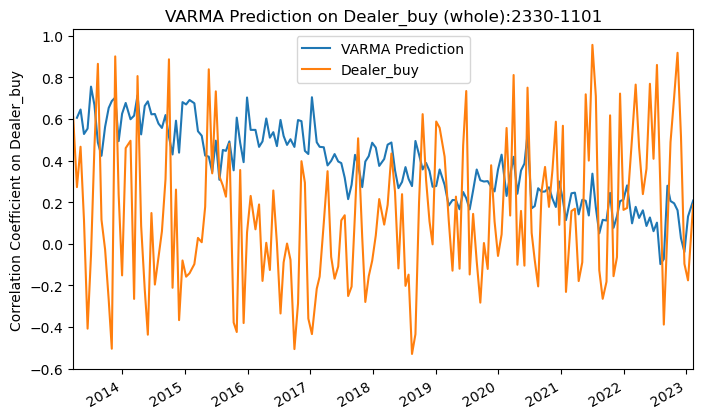

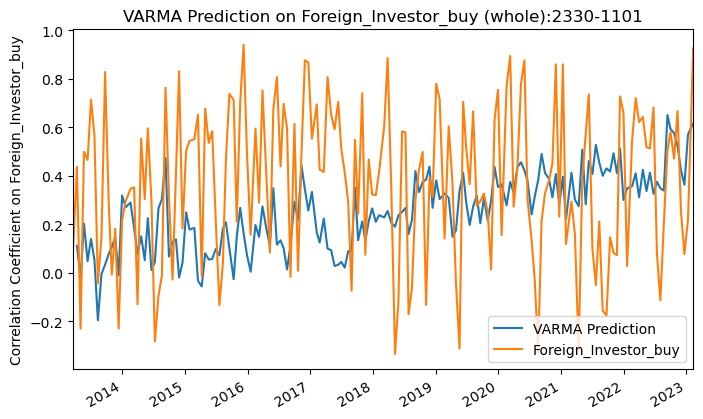

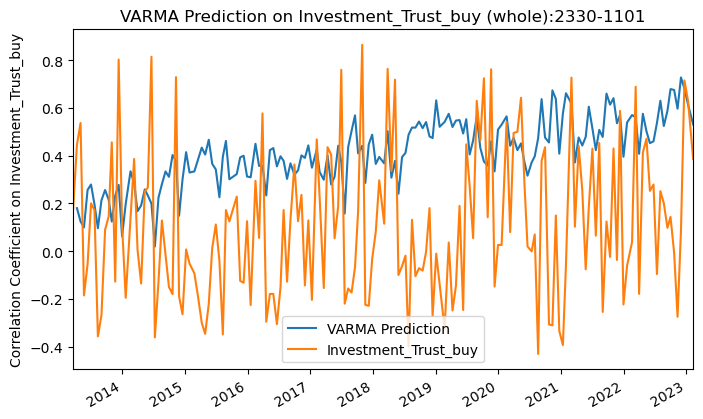

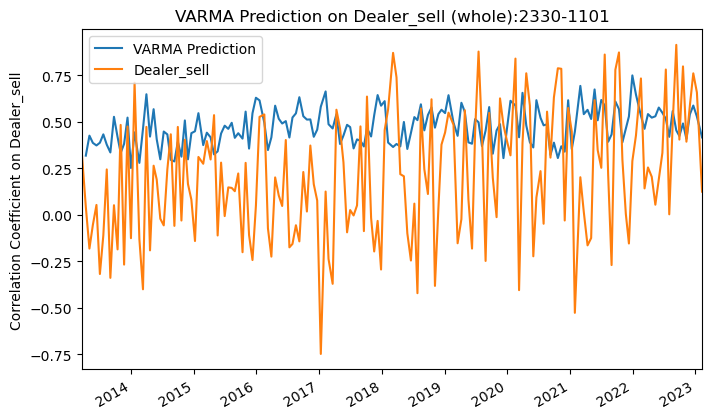

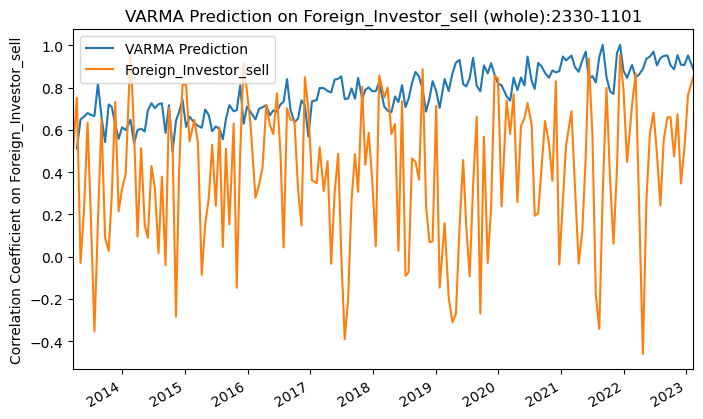

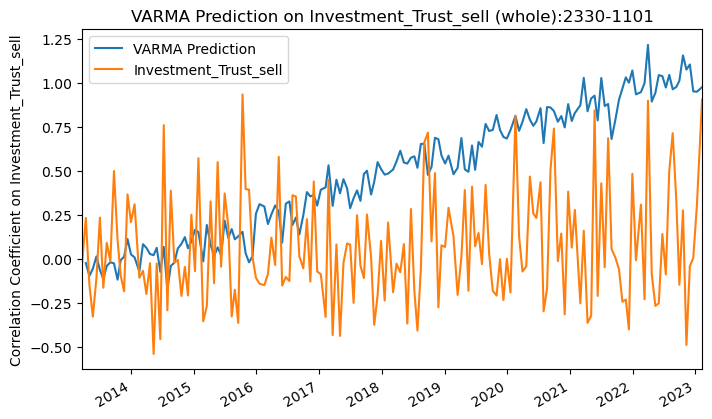

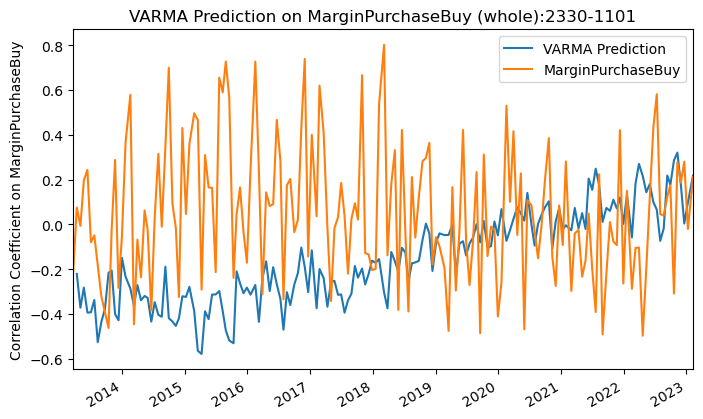

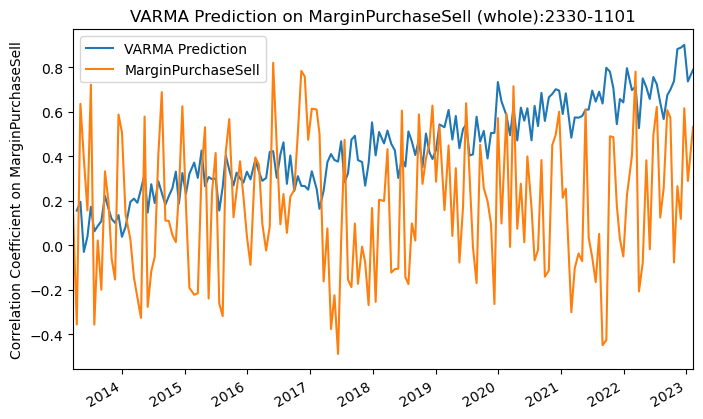

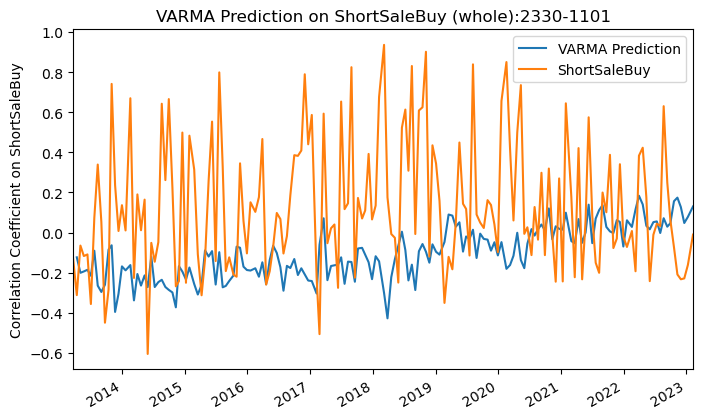

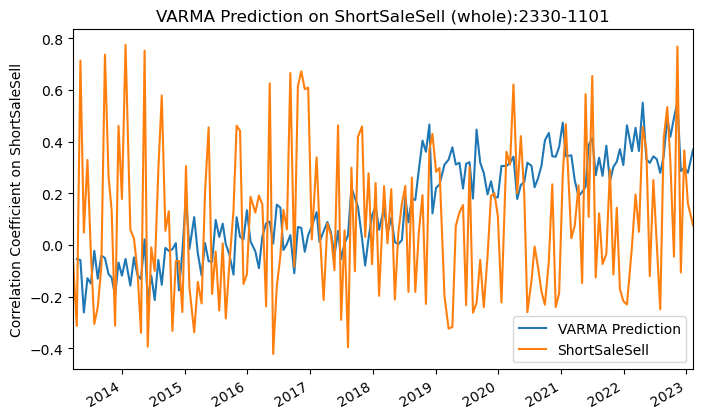

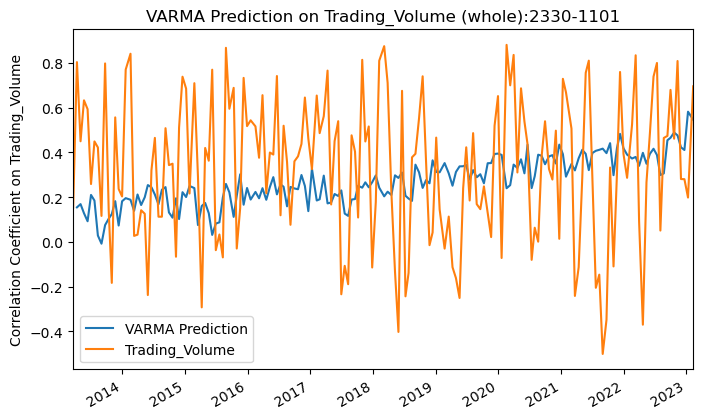

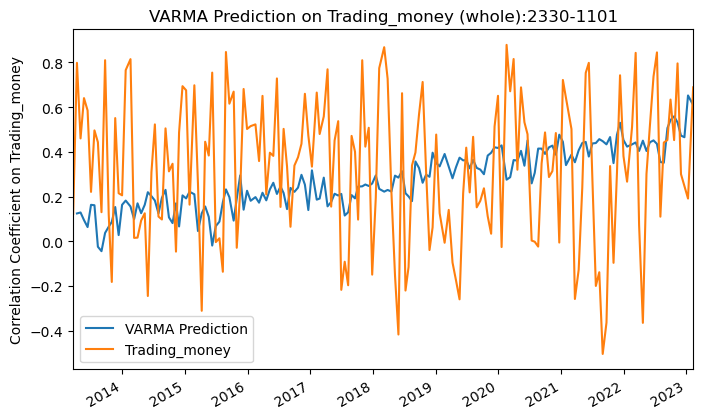

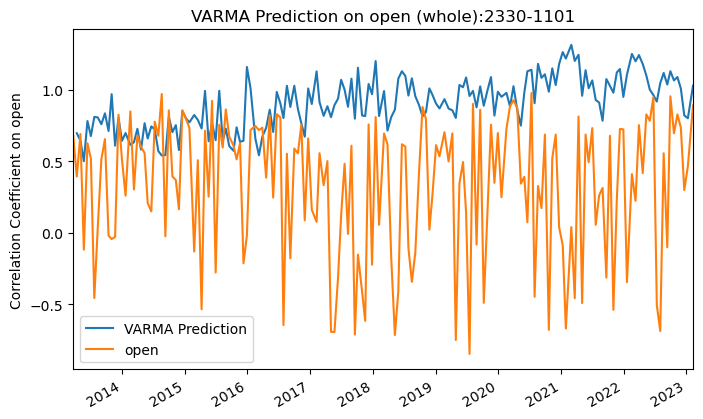

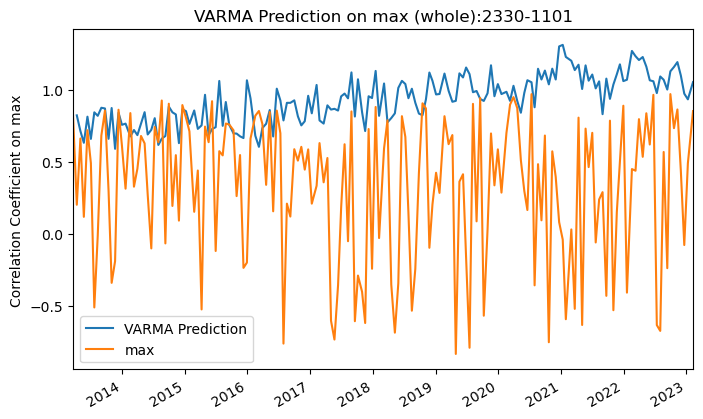

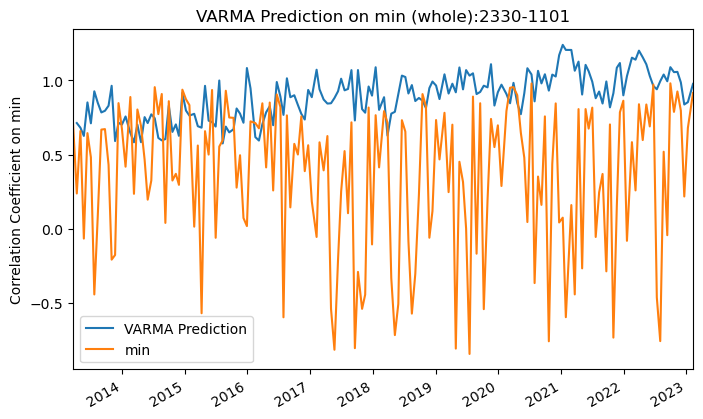

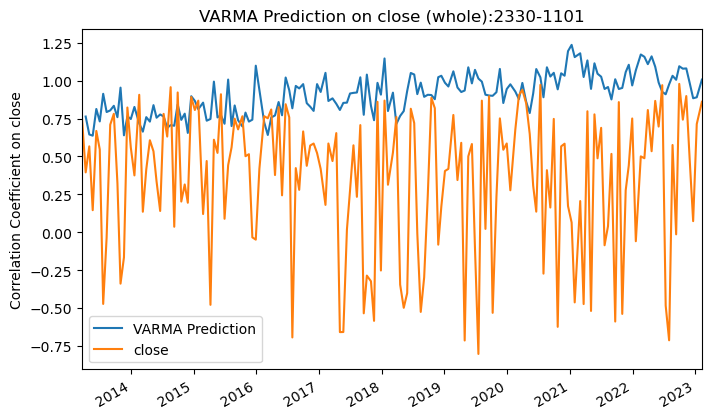

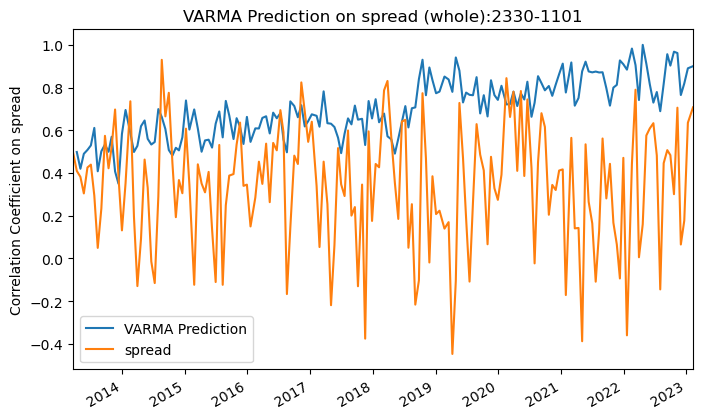

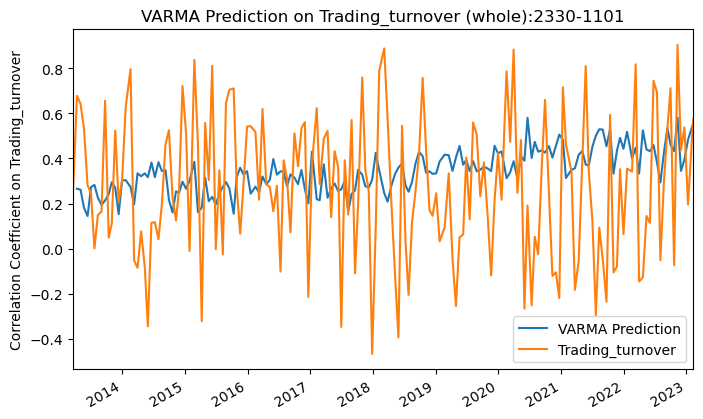

In [38]:
arima_tools.visualize(corr_matrix, varma_prediction, '2330', '1101', 'VARMA', 0, 0, nobs)

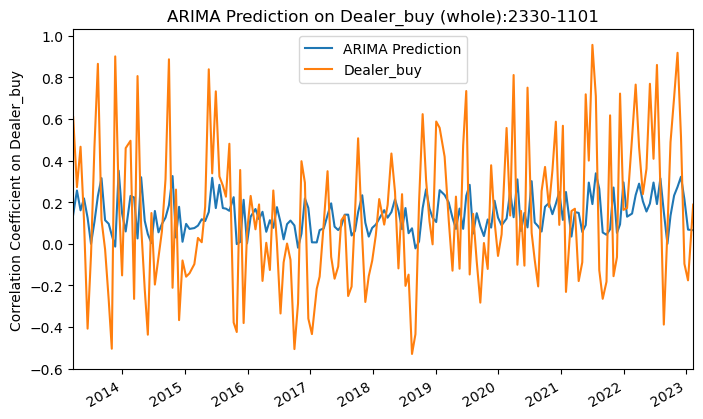

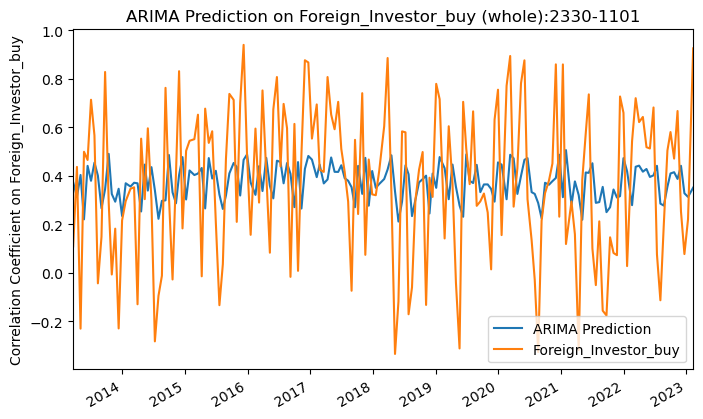

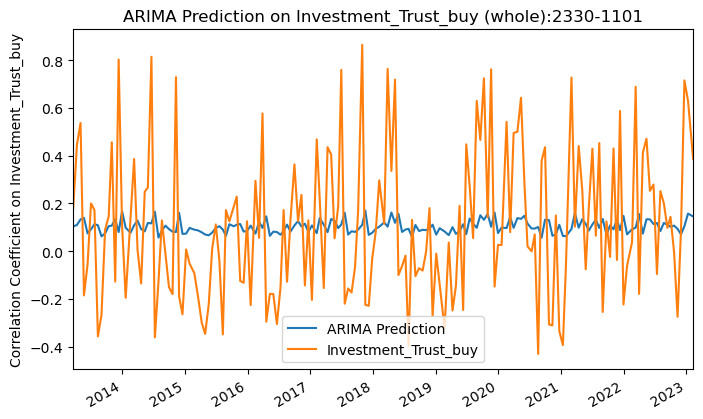

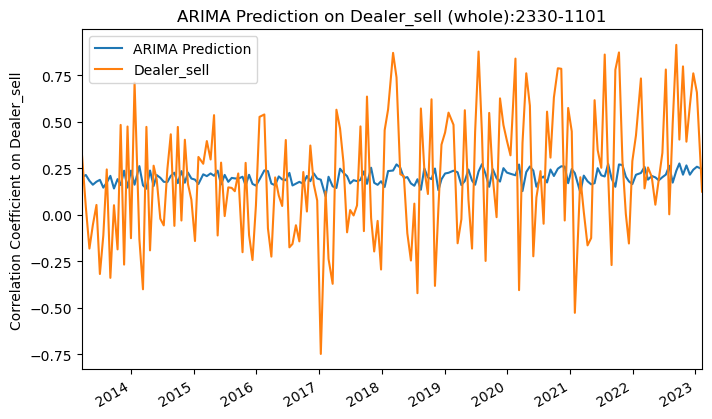

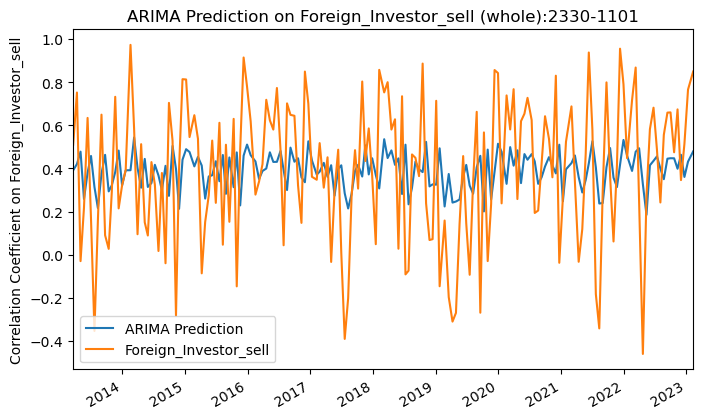

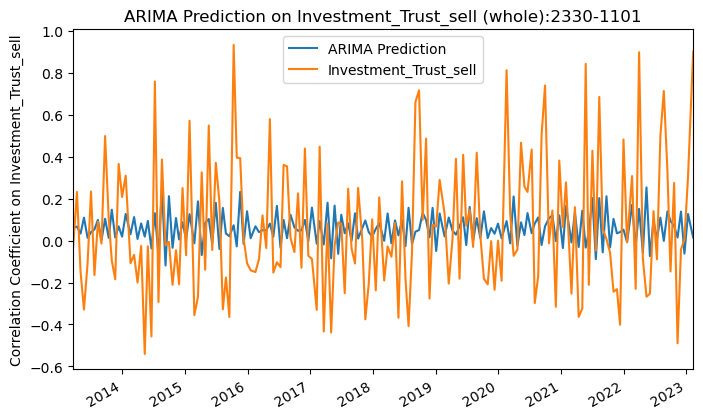

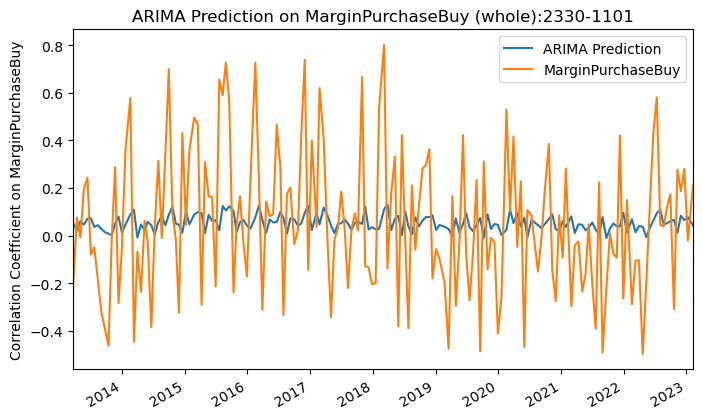

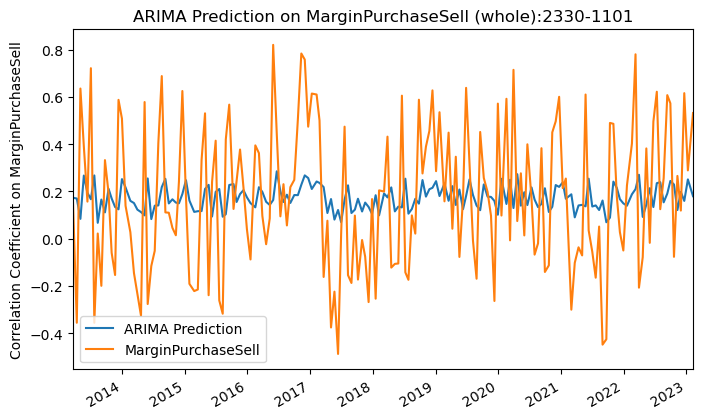

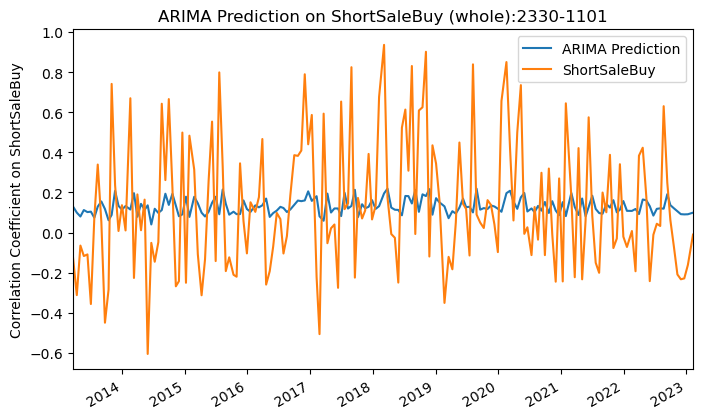

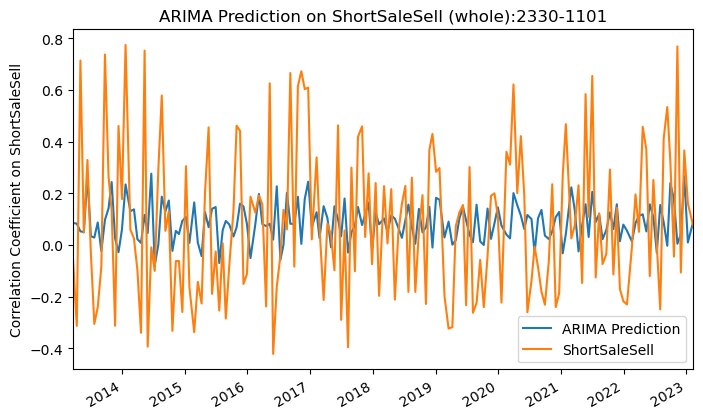

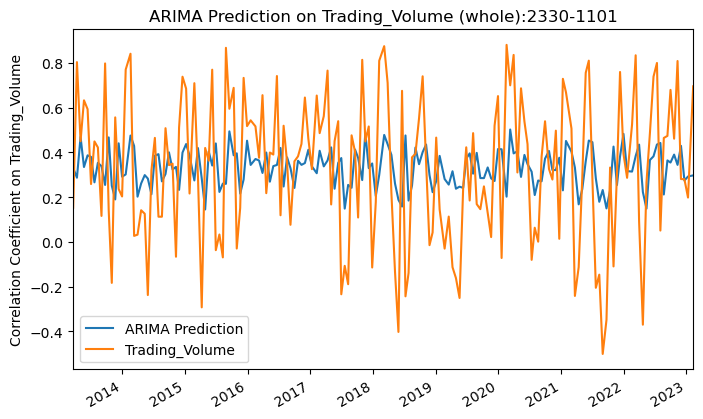

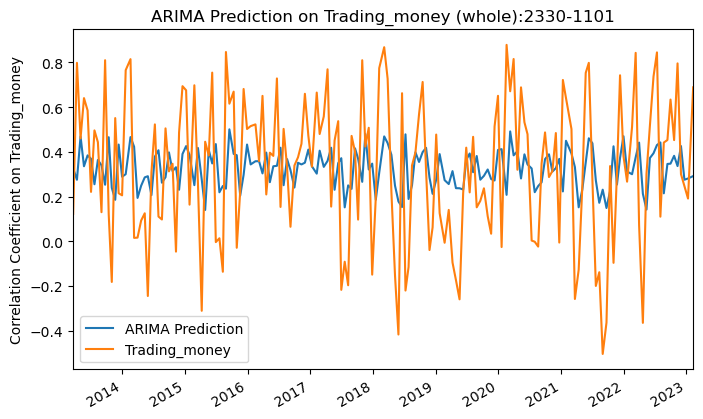

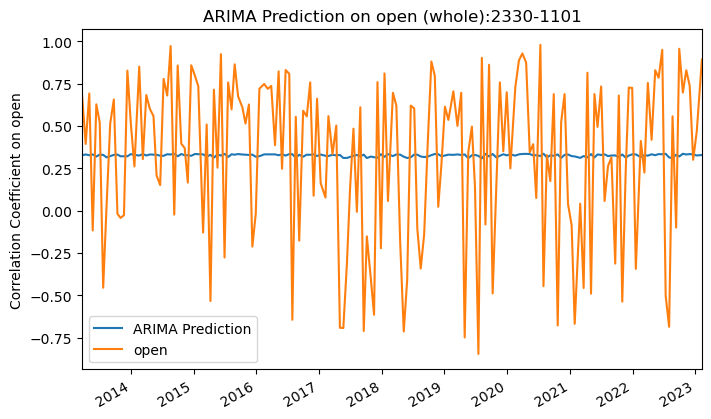

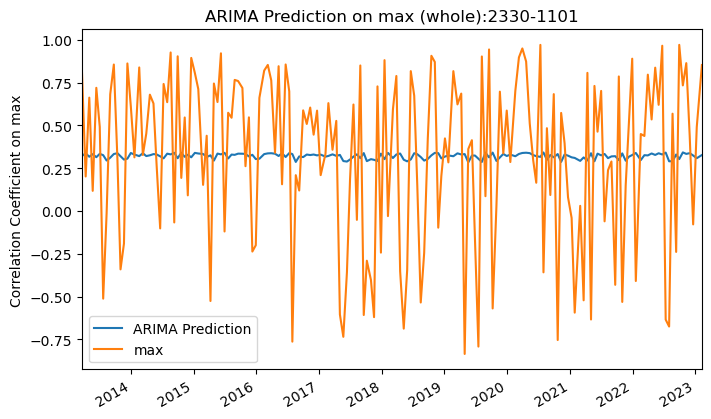

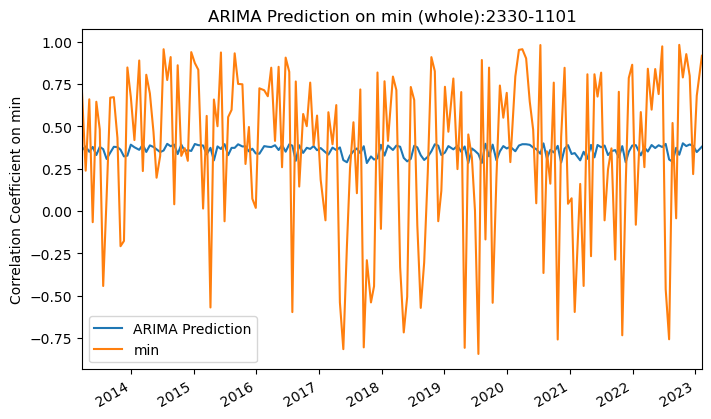

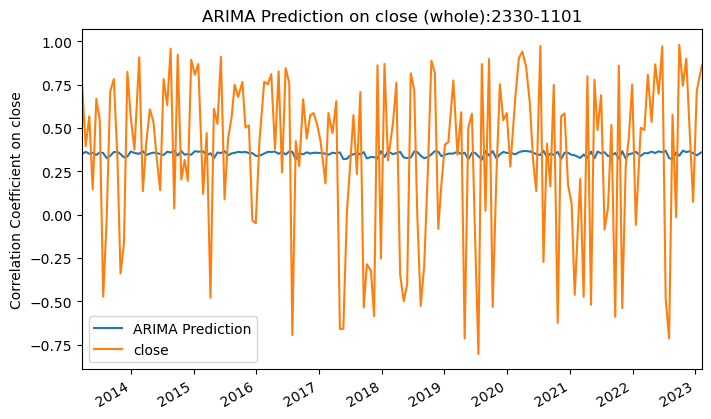

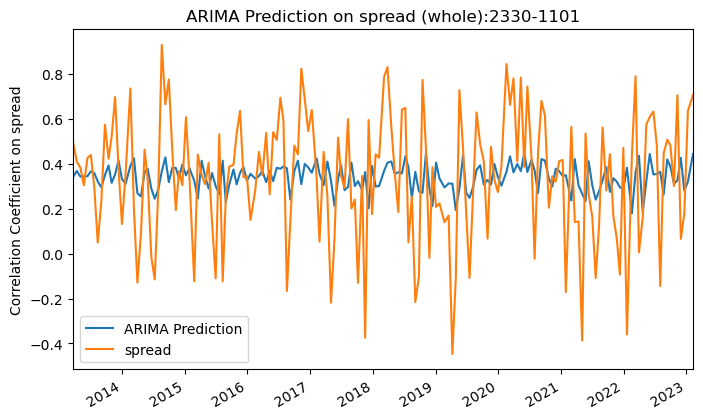

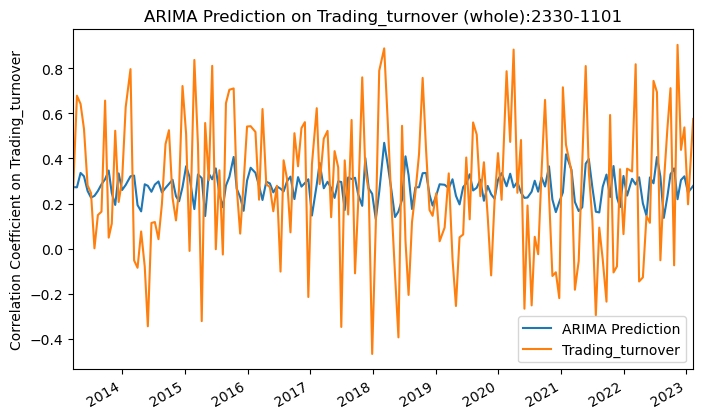

In [40]:
arima_tools.visualize(corr_matrix, arima_prediction, '2330', '1101', 'ARIMA', 0, 0, nobs)

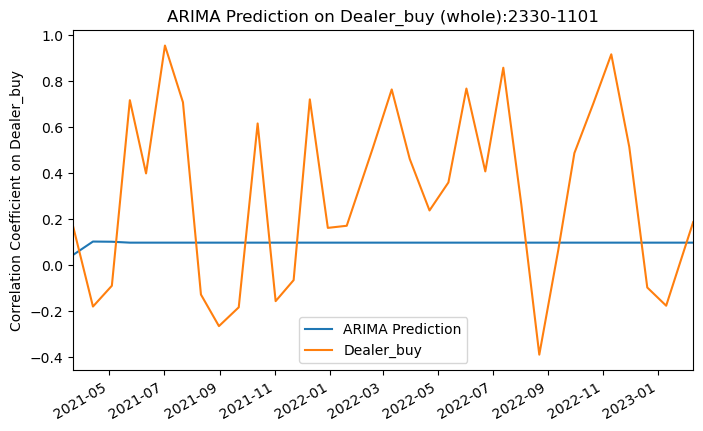

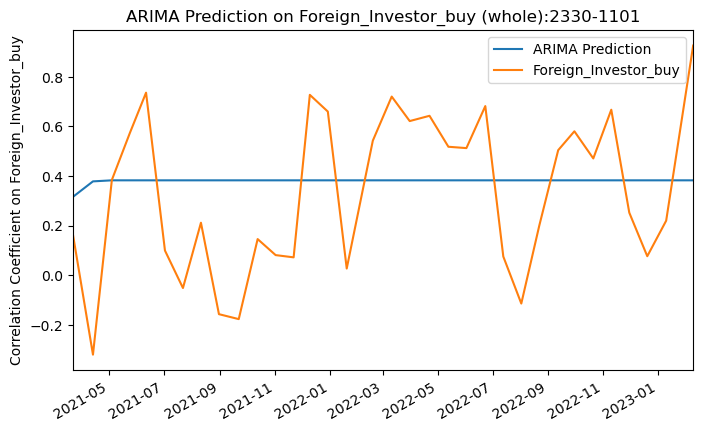

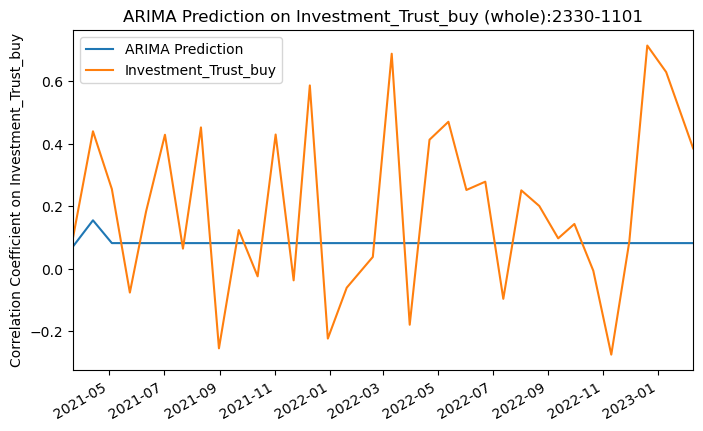

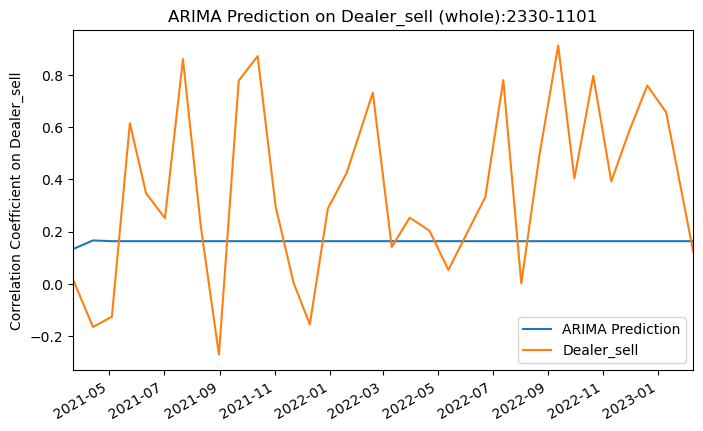

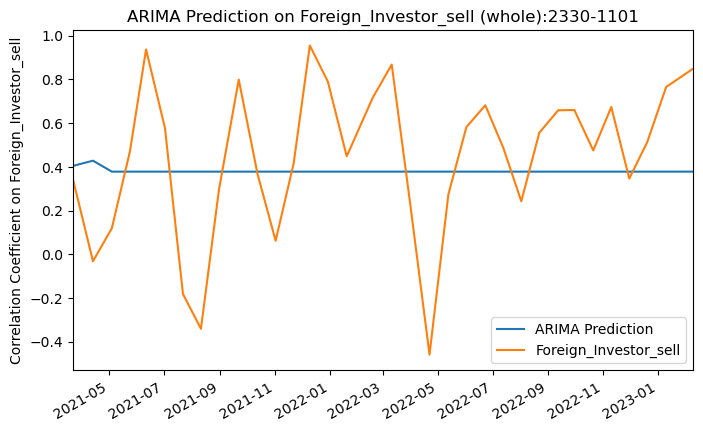

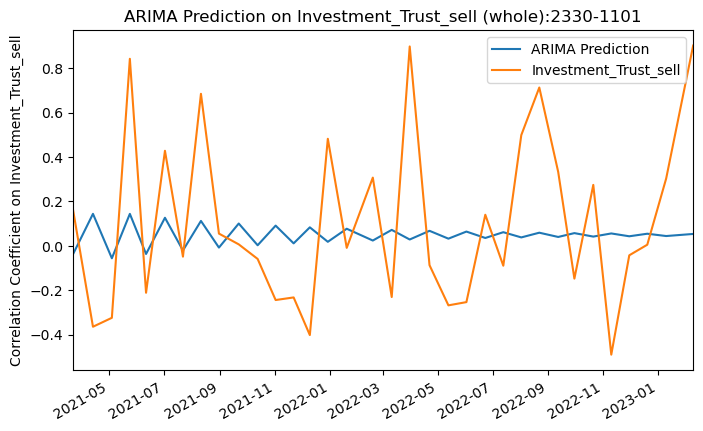

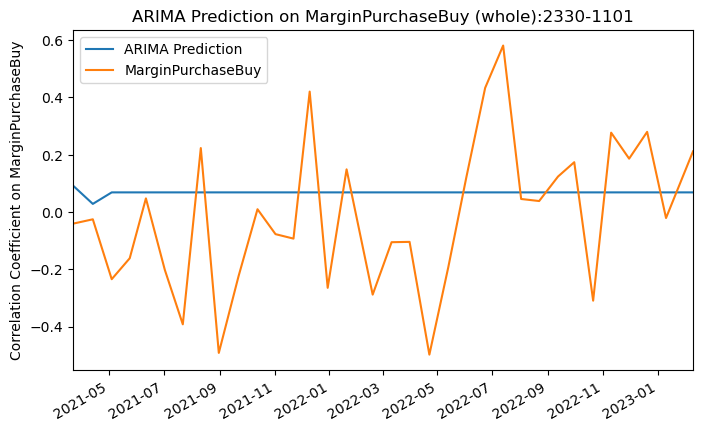

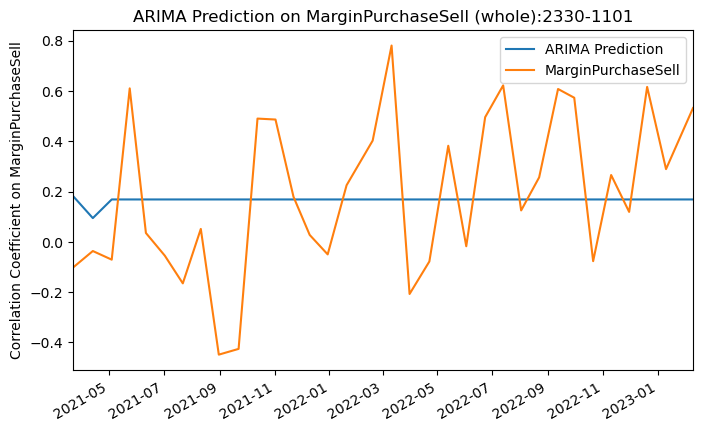

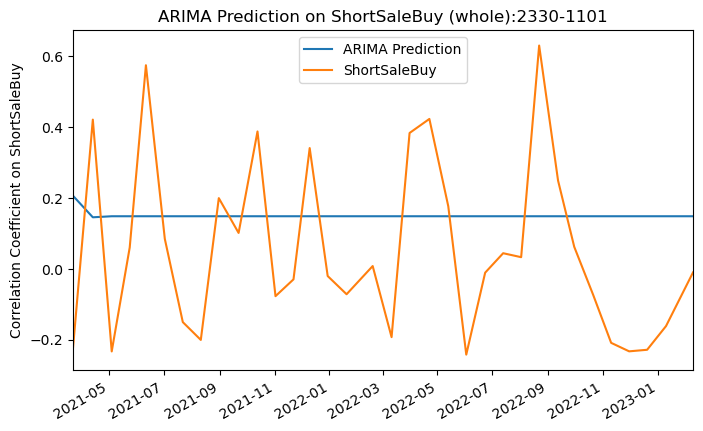

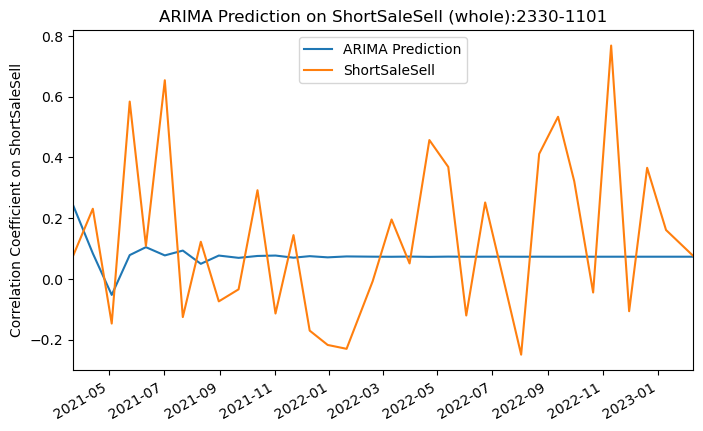

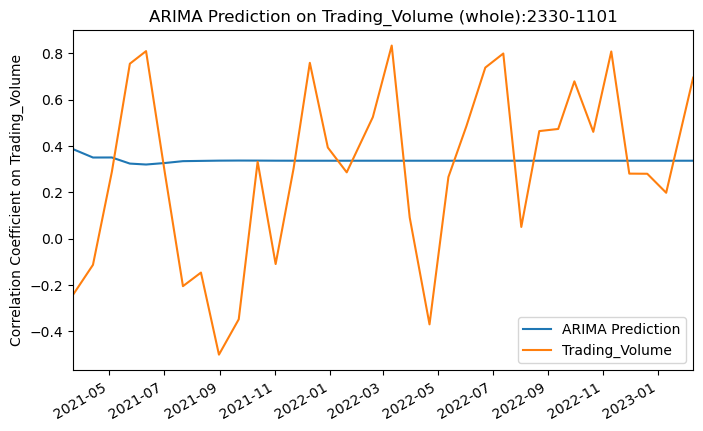

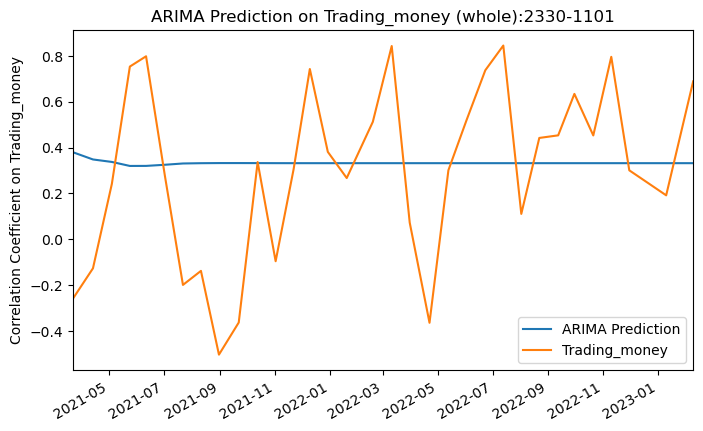

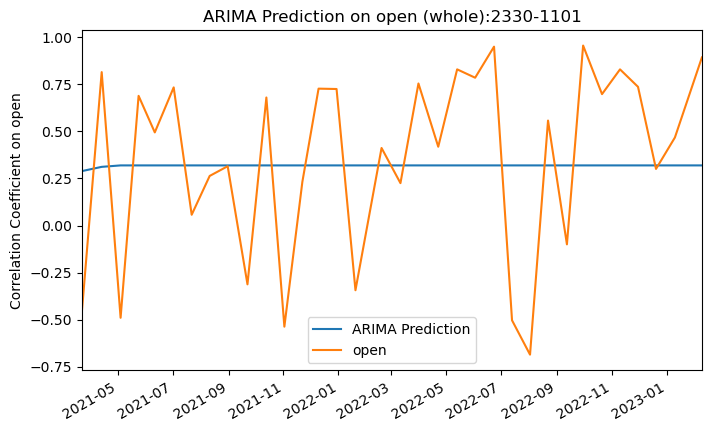

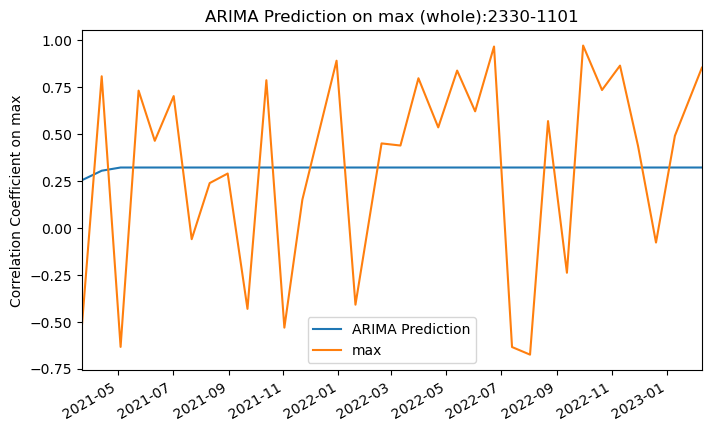

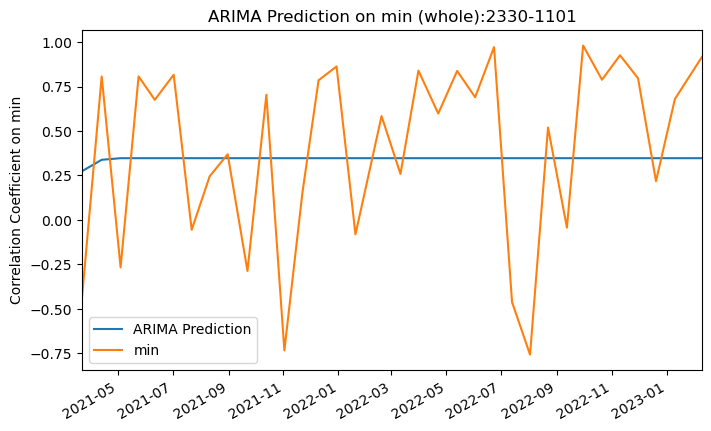

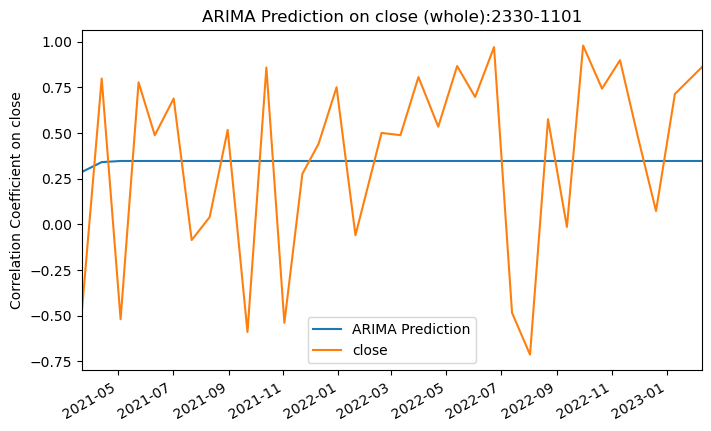

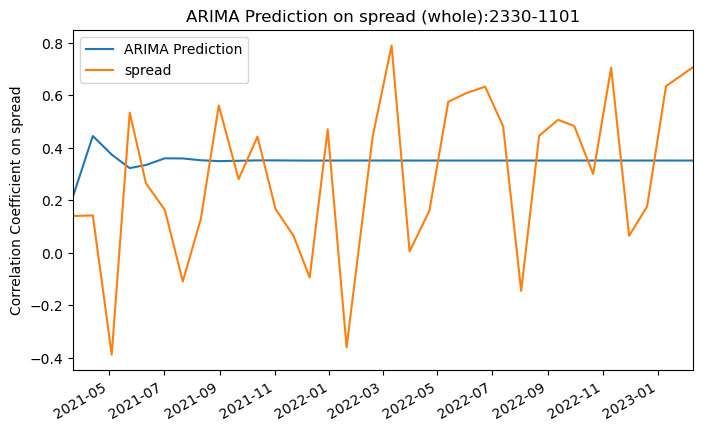

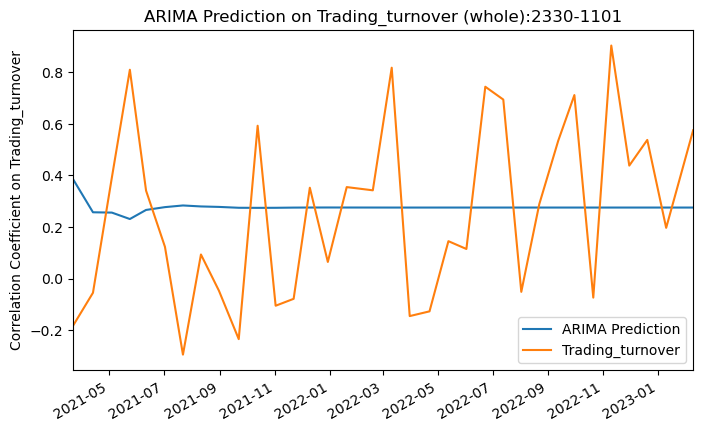

In [42]:
arima_tools.visualize(corr_matrix[-nobs:], arima_test_forecast, '2330', '1101', 'ARIMA', 0, 0, nobs)